In [1]:
from tools import *
from omegaconf import OmegaConf
from pprint import PrettyPrinter
from models._main import get_model
from models._utils import print_parameters

sns.set_style("whitegrid")
pp = PrettyPrinter(indent=4, width=100, compact=True)

CUDA device found.


In [ ]:
# %load_ext cudf.pandas  # pandas operations now use the GPU!
# import cudf.pandas
# cudf.pandas.install()
# import pandas as pd
# pd

# Color and Marker code

*Returns the legend code that is used across all plots.*

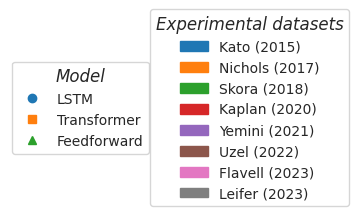

{   'color_legend': [   <matplotlib.patches.Patch object at 0x14c647835670>,
    'dataset_labels': [   'Kato (2015)', 'Nichols (2017)', 'Skora (2018)', 'Kaplan (2020)',
                          'Yemini (2021)', 'Uzel (2022)', 'Flavell (2023)', 'Leifer (2023)'],
    'ds_color_code': {   'Flavell': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
                         'Kaplan': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                         'Kato': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                         'Leifer': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                         'Nichols': (1.0, 0.4980392156862745, 0.054901960784313725),
                         'Skora': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                         'Uzel': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
                         'Yemini': (0.5803921568627451, 0.4039215686

In [2]:
leg_code = legend_code()
pp.pprint(leg_code)

# Model Parameters

In [3]:
model_config = OmegaConf.load("../../configs/submodule/model.yaml")
model_config.model.use_this_pretrained_model = None
model = get_model(model_config.model)
print_parameters(model, verbose=True)

+-----------------------------+------------+-----------+
|            Module           | Parameters | Trainable |
+-----------------------------+------------+-----------+
|    input_hidden.0.weight    |   154624   |    True   |
|     input_hidden.0.bias     |    512     |    True   |
|    input_hidden.2.weight    |    512     |    True   |
|     input_hidden.2.bias     |    512     |    True   |
| hidden_hidden.ffwd.0.weight |   262144   |    True   |
|  hidden_hidden.ffwd.0.bias  |    512     |    True   |
|        linear.weight        |   154624   |    True   |
|         linear.bias         |    302     |    True   |
+-----------------------------+------------+-----------+
Total Parameters: 573742
Total Trainable Parameters: 573742


(573742, 573742)

# Dataset information

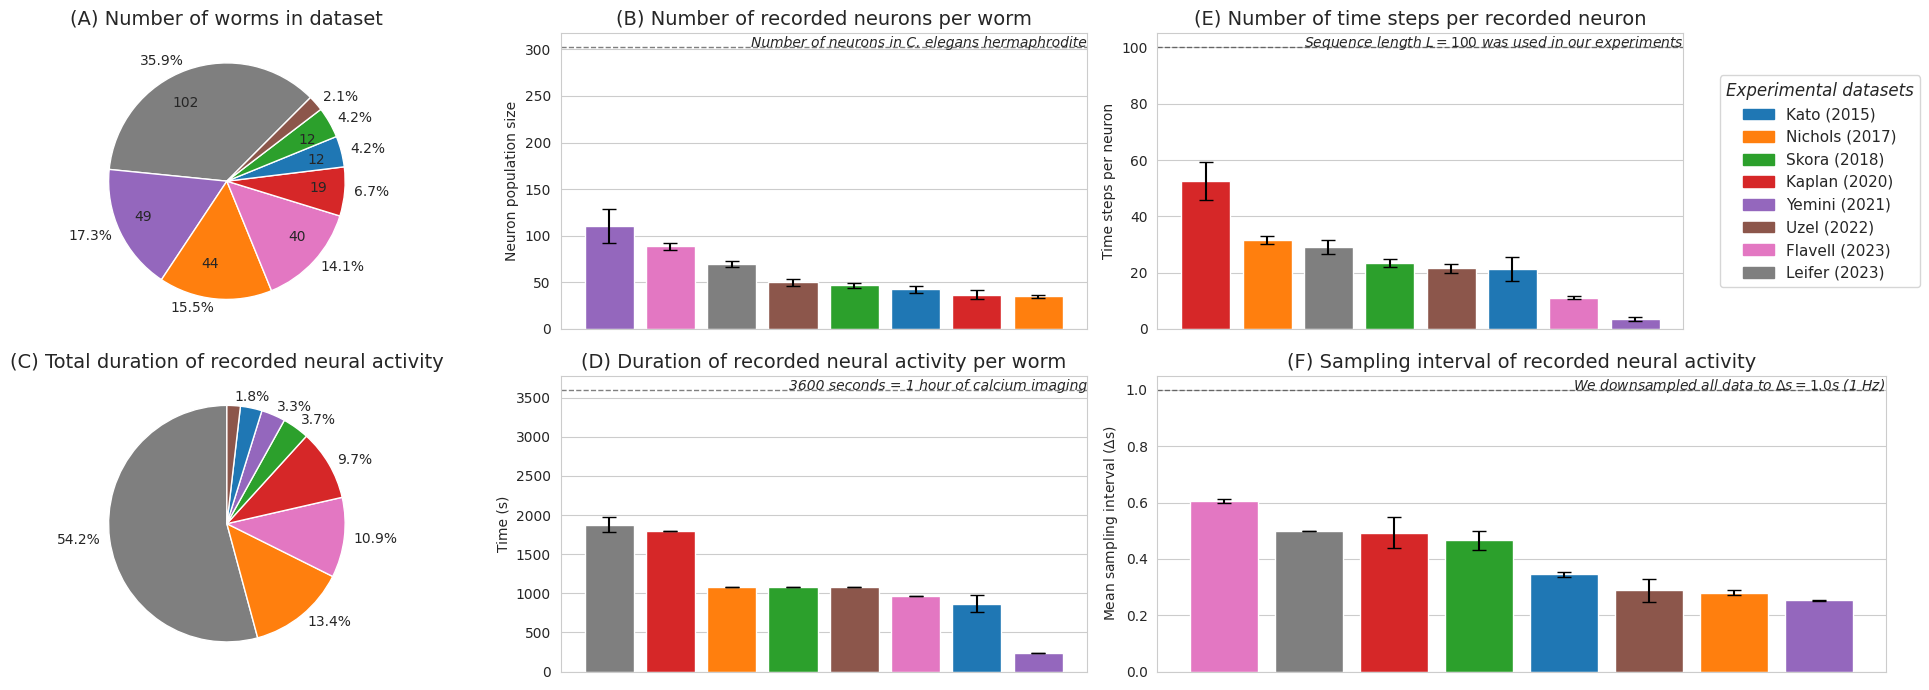

In [4]:
fig1_path_dict = {
    "train_dataset_info": "/om2/user/qsimeon/worm-graph/data/train_AllExperimental/train_dataset_info.csv",  # Path to train dataset info => extract number of train time steps
    "val_dataset_info": "/om2/user/qsimeon/worm-graph/data/validation_AllExperimental/val_dataset_info.csv",  # Path to val. dataset info => extract number of val. time steps
    "combined_dataset_info": "/om2/user/qsimeon/worm-graph/data/combined_AllExperimental/combined_dataset_info.csv",  # Path to combined dataset info => extract total number of worms and time step interval
}

# NOTE: Error bars on bar plots show +/- 2 SEM
dataset_info = dataset_information(path_dict=fig1_path_dict, legend_code=leg_code)

# Data scaling

In [5]:
# Specify path to where results are stored for this experiment
results_dir = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_time_steps/experimental"

nts_experiments = {
    "Feedforward": [  # Feedforward trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_27_03"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_42_34"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_57_40"),
    ],
    "LSTM": [  # LSTM trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_51_11"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_45_46"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_58_30"),
    ],
    "Transformer": [  # Transformer trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_53_07"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_47_28"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_58_54"),
    ],
}

# Retrieve the relevant results
data_results = data_scaling_df(nts_experiments)

# Building the DataFrame took ~35s on OpenMind cluster
data_results

,experiment_ID,model_type,hidden_size,num_parameters,num_worms,num_time_steps,time_steps_per_neuron,num_named_neurons,min_val_loss,val_baseline
0,exp0,FeatureFFNN,512,573742,5,3148,11.000000,193,0.826815,0.010516
1,exp1,FeatureFFNN,512,573742,10,5071,9.316316,219,0.532222,0.010516
2,exp10,FeatureFFNN,512,573742,55,31666,9.862745,243,0.108318,0.010516
3,exp11,FeatureFFNN,512,573742,60,40776,11.253472,243,0.085431,0.010516
4,exp12,FeatureFFNN,512,573742,65,36987,9.862745,243,0.095273,0.010516
...,...,...,...,...,...,...,...,...,...,...
493,exp55,NeuralTransformer,262,573296,280,174569,11.114583,247,0.044973,0.010516
494,exp6,NeuralTransformer,262,573296,35,20149,10.568627,242,0.152709,0.010516
495,exp7,NeuralTransformer,262,573296,40,19011,7.110525,243,0.153420,0.010516
496,exp8,NeuralTransformer,262,573296,45,24774,7.851485,243,0.122836,0.010516


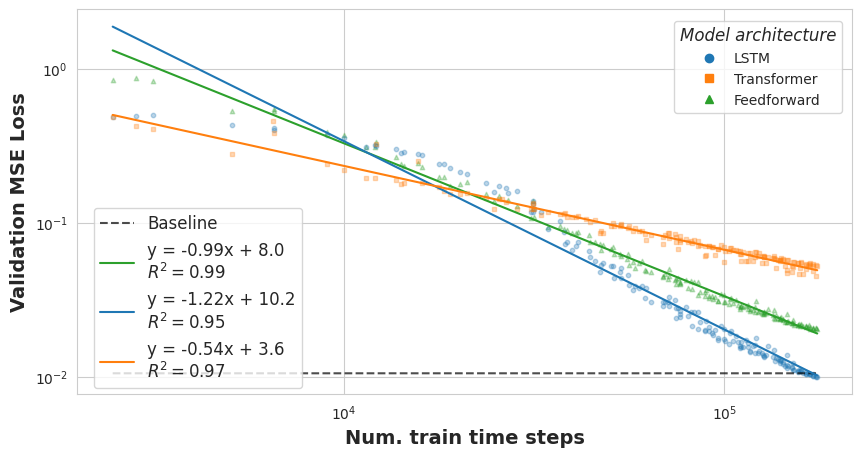

In [6]:
data_scaling_plot(data_results, legend_code=leg_code)

## Data Scaling for Individual Datasets

In [7]:
# Retrieve the relevant results
scaling_slope_results = scaling_slopes_df(nts_experiments)

# Building the DataFrame took ~3m5s on OpenMind cluster
scaling_slope_results

,experiment_ID,model_type,validation_dataset,individual_validation_loss,individual_baseline_loss,num_parameters,num_worms,num_time_steps,min_val_loss,val_baseline
0,exp0,FeatureFFNN,Kato2015,0.723594,0.013651,573742,5,3148,0.826815,0.010516
1,exp0,FeatureFFNN,Nichols2017,0.713596,0.010331,573742,5,3148,0.826815,0.010516
2,exp0,FeatureFFNN,Skora2018,0.790223,0.007510,573742,5,3148,0.826815,0.010516
3,exp0,FeatureFFNN,Kaplan2020,0.821712,0.003506,573742,5,3148,0.826815,0.010516
4,exp0,FeatureFFNN,Yemini2021,1.088353,0.010871,573742,5,3148,0.826815,0.010516
...,...,...,...,...,...,...,...,...,...,...
3979,exp9,NeuralTransformer,Kaplan2020,0.068865,0.003506,573296,50,28532,0.122155,0.010516
3980,exp9,NeuralTransformer,Yemini2021,0.144439,0.010871,573296,50,28532,0.122155,0.010516
3981,exp9,NeuralTransformer,Uzel2022,0.144689,0.007564,573296,50,28532,0.122155,0.010516
3982,exp9,NeuralTransformer,Flavell2023,0.114526,0.008092,573296,50,28532,0.122155,0.010516


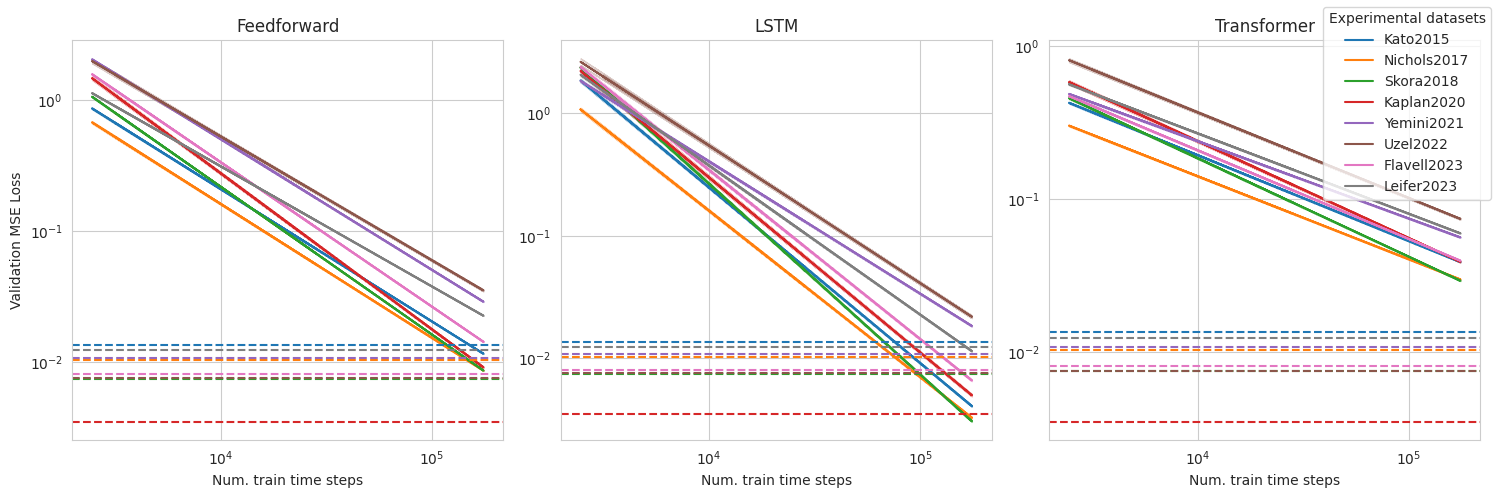

In [8]:
scaling_slopes_plot(scaling_slope_results, legend_code=leg_code)

# Number of Parameters Scaling

In [9]:
# Instead of plotting against the hidden size, plot against the number of parameters.
# The hidden size is simply the "knob" that we turn (i.e. the variable) as way to vary the number of parameters.

# Specify path to where results are stored for this experiment
results_dir = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/experimental"

size_experiments = {
    "Feedforward": [  # Feedforward trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_47_42"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_41_41"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_32_53"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_01_12"),
    ],
    "LSTM": [  # LSTM trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_49_29"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_42_25"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_33_22"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_13_04"),
    ],
    "Transformer": [  # Transformer trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_51_19"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_45_03"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_39_53"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_15_42"),
    ],
}

# Retrieve the relevant results
size_results = data_scaling_df(size_experiments)

# Building the DataFrame took ~25s on OpenMind cluster
size_results

,experiment_ID,model_type,hidden_size,num_parameters,num_worms,num_time_steps,time_steps_per_neuron,num_named_neurons,min_val_loss,val_baseline
0,exp0,FeatureFFNN,1024,1671470,284,176402,11.0,247,0.026755,0.010516
1,exp1,FeatureFFNN,1152,2027822,284,176402,11.0,247,0.027618,0.010516
2,exp10,FeatureFFNN,2304,6709550,284,176402,11.0,247,0.032370,0.010516
3,exp11,FeatureFFNN,2432,7393582,284,176402,11.0,247,0.032139,0.010516
4,exp12,FeatureFFNN,2560,8110382,284,176402,11.0,247,0.032187,0.010516
...,...,...,...,...,...,...,...,...,...,...
188,exp5,NeuralTransformer,28,22226,284,176402,11.0,247,0.254144,0.010516
189,exp6,NeuralTransformer,32,26126,284,176402,11.0,247,0.237500,0.010516
190,exp7,NeuralTransformer,36,30218,284,176402,11.0,247,0.228002,0.010516
191,exp8,NeuralTransformer,40,34502,284,176402,11.0,247,0.212939,0.010516


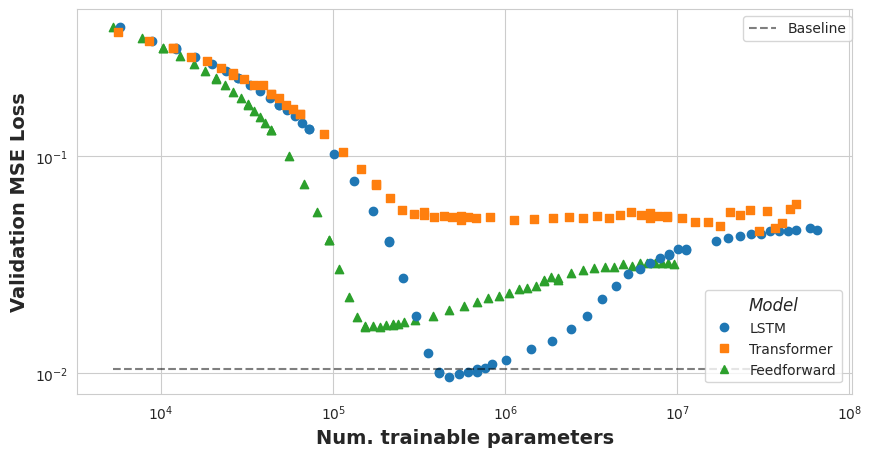

In [10]:
hidden_scaling_plot(size_results, legend_code=leg_code)

# STOP HERE! 
## Got everything above this point to work.

In [ ]:
exit(0)

# Cross-dataset Generalization

*This function automatically loads the results from the indicated experiments and displays a heatmap plot showing the validation loss on individual experimental datasets after a model has been trained (from scratch) using a single experimental dataset.*

*You need to specify the model names respective to each experiment and also the legend color code.*

In [ ]:
experiment_log_folders = [
    os.path.join("results", "CDS_LINEAR"),  # Linear trial 1
    os.path.join("results", "CDS_LSTM"),  # LSTM trial 1
    os.path.join("results", "CDS_TRANSFORMER"),  # Transformer trial 1
]

model_names = ["Feedforward", "LSTM", "Transformer"]

cross_dataset(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
)

# Predictions

*Load and plot the predictions for the same neuron across different datasets. You need to determine which neurons are common to all datasets (I did it manually).*

In [ ]:
experiment_log_folders = [
    os.path.join("results", "NTS_LSTM_2"),  # LSTM trial 1
    os.path.join("results", "NTS_TRANSFORMER_2"),  # Transformer trial 1
    os.path.join("results", "NTS_LINEAR_2"),  # Linear trial 1
]

model_names = ["LSTM", "Transformer", "Linear"]

ds_type = "val"  # we are plotting the predictions using the validation dataset (data never seen during training, second split)
exp = "exp5"  # model trained with maximum amount of data (best model to use for predictions)
neuron_to_plot = "AVER"  # neuron we want to plot

teacher_forcing(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
    ds_type=ds_type,
    exp=exp,
    neuron_to_plot=neuron_to_plot,
)

In [ ]:
autoregressive(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
    ds_type=ds_type,
    exp=exp,
    neuron_to_plot=neuron_to_plot,
)

# (Sup. fig) Prediction gap

*Loads the relevant results and plots the refinement of the prediction plot as the amount of training data for the LSTM model increases.*

In [ ]:
pred_gap_df = prediction_gap(
    exp_nts_log_dir=os.path.join("results", "NTS_LSTM_1"),
    legend_code=leg_code,
    neuronID="AVER",
    wormID="worm1",
    datasetID="Flavell2023",
)